### Fairlearn en Colab

Este notebook introductorio brinda un ejemplo básico sobre la herramienta Fairlearn de Microsoft. Se usarán funcionalidades especificas con el dataset 'UCI Cencus Income' y se brindarán enlaces para una mayor comprensión.

Nota: Fairlearn hace parte del framework [Responsible AI Toolbox](https://github.com/microsoft/responsible-ai-toolbox).

* *Para una mayor comprensión de las funcionalidades y definiciones visite esta [Guia](https://fairlearn.org/v0.8/user_guide/index.html)*

* *Para más información sobre este notebook visite este [link](https://fairlearn.org/v0.8/quickstart.html)*

* *Para más información sobre la herramienta visite este [link](https://fairlearn.org/)*

#### Librerias

In [ ]:
%pip install fairlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 KB 7.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, precision_score
from sklearn.tree import DecisionTreeClassifier

from fairlearn.metrics import MetricFrame, selection_rate, count, false_negative_rate, false_positive_rate
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

pd.set_option('display.max_columns', None)
np.random.seed(0)

#### Fairlearn

El paquete Fairlearn tiene dos componentes:

"*Métricas* para evaluar qué grupos se ven afectados negativamente por un modelo y para comparar varios modelos en términos de varias métricas de equidad y precisión".

"*Algoritmos* para mitigar la injusticia en una variedad de tareas de IA y a lo largo de una variedad de definiciones de equidad".

* *Para más información sobre la API visite el siguiente [link](https://fairlearn.org/v0.8/api_reference/index.html)*


#### Dataset

El siguiente ejemplo trata sobre la clasificación binaria, pero Fairlearn tambien admite regresión.

"Para este ejemplo, usamos el conjunto de datos [UCI Cencus adult](https://archive.ics.uci.edu/ml/datasets/Adult) donde el objetivo es predecir si una persona gana más (label 1) o menos (label 0) de $50,000 al año".

In [ ]:
# Sklearn tiene integrado el repositorio openml
data = fetch_openml(data_id=1590, as_frame=True)

In [ ]:
data_df = data.data
data_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States


In [ ]:
# One-hot encoding de las caracteristicas
X = pd.get_dummies(data.data)

# Establecer label
y_true = (data.target == '>50K') * 1

Male      32650
Female    16192
Name: sex, dtype: int64


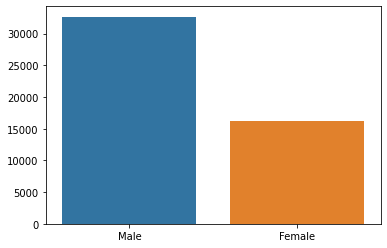

In [ ]:
sex = data.data['sex']
print(sex.value_counts())

plt.figure()
sns.barplot(x=['Male', 'Female'], y=[sex.value_counts()[0], sex.value_counts()[1]])
plt.show()

#### Evaluación de métricas relacionadas con la equidad

"Fairlearn proporciona métricas relacionadas con la equidad que se pueden comparar entre grupos y para la población en general. Usando definiciones de métricas existentes de [`scikit-learn`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics), podemos evaluar métricas para subgrupos dentro de los datos de la siguiente manera".

Se usará `sex` como característica sensible (`sensitive_features`) para crear los subgrupos.

In [ ]:
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
classifier.fit(X, y_true)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=10)

In [ ]:
y_pred = classifier.predict(X)

# Métrica accuracy y sensitive_features=sex
gm = MetricFrame(metrics=accuracy_score, y_true=y_true, y_pred=y_pred, sensitive_features=sex)

print(f'Accuracy general: {gm.overall}')

Accuracy general: 0.8443552680070431


In [ ]:
print(f'Accuracy por subgrupos.\n\nAccuracy en mujeres: {gm.by_group[0]}\nAccuracy en hombres: {gm.by_group[1]}')

Accuracy por subgrupos.

Accuracy en mujeres: 0.9251482213438735
Accuracy en hombres: 0.8042879019908117


"Fairlearn tiene muchas otras métricas estándar incorporadas, como la tasa de selección (`selection_rate`), es decir, el porcentaje de la población que tiene '1' como etiqueta".

In [ ]:
sr = MetricFrame(metrics=selection_rate, y_true=y_true, y_pred=y_pred, sensitive_features=sex)

sr.overall

0.16385487899758405

In [ ]:
sr.by_group

sex
Female    0.063550
Male      0.213599
Name: selection_rate, dtype: float64

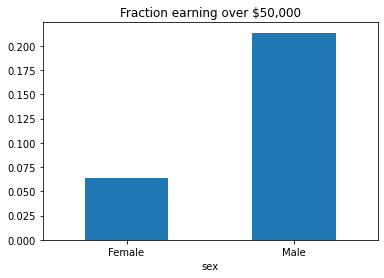

In [ ]:
fig = sr.by_group.plot.bar(
    legend=False, rot=0, title="Fraction earning over $50,000"
)

"Fairlearn también nos permite trazar rápidamente estas métricas desde el `fairlearn.metrics.MetricFrame`"

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4219a6ee0>,
      dtype=object)

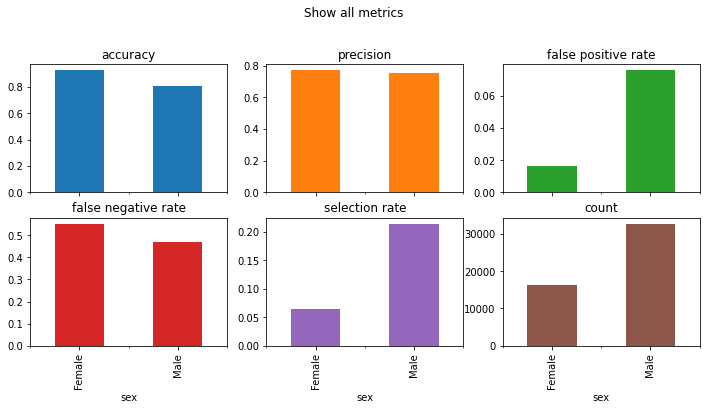

In [ ]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}

metric_frame = MetricFrame(metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=sex)

metric_frame.by_group.plot.bar(subplots=True, layout=[3, 3], legend=False, figsize=[12, 8], title="Show all metrics")

#### Mitigar la disparidad

"Si observamos disparidades entre grupos, es posible que deseemos crear un nuevo modelo mientras especificamos una restricción de equidad adecuada". 

"Tenga en cuenta que la elección de las restricciones de equidad es crucial para el modelo resultante y varía según el contexto de la aplicación. Si la tasa de selección es muy relevante para la equidad en este ejemplo artificial, podemos intentar mitigar la disparidad observada utilizando la restricción de equidad correspondiente denominada Paridad demográfica (`DemographicParity`)". 

"En las aplicaciones del mundo real, debemos tener en cuenta el contexto sociotécnico al tomar tales decisiones. La técnica de mitigación de gradiente exponencial (`ExponentiatedGradient`) utilizada se ajusta al clasificador proporcionado utilizando la paridad demográfica como objetivo, lo que lleva a una diferencia muy reducida en la tasa de selección ('selection rate')".

In [ ]:
constraint = DemographicParity() # restricción de equidad
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
mitigator = ExponentiatedGradient(classifier, constraint) # técnica de mitigación de gradiente exponencial
mitigator.fit(X, y_true, sensitive_features=sex)

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.DemographicParity object at 0x7fa41edbc370>,
                      estimator=DecisionTreeClassifier(max_depth=4,
                                                       min_samples_leaf=10),
                      nu=0.0008201769357601916)

In [ ]:
y_pred_mitigated = mitigator.predict(X)

In [ ]:
sr_mitigated = MetricFrame(metrics=selection_rate, y_true=y_true, y_pred=y_pred_mitigated, sensitive_features=sex)
print(sr_mitigated.overall)

0.16614798738790384


In [ ]:
print(sr_mitigated.by_group)

sex
Female    0.155262
Male      0.171547
Name: selection_rate, dtype: float64
